In [1]:
import lxml.etree as etree
import subprocess
import tempfile
import time
import psutil
from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap
import os

%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np
from shapely.wkt import loads
from shapely.geometry import Point
import osr
import ogr
from shapely import geometry

import pandas as pd
from geopandas import GeoDataFrame

In [2]:
df = pd.read_csv('s1_prd.csv')

In [3]:
df

,Unnamed: 0,enclosure,identifier,self,startdate,track,wkt,local_path
0,4,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22T11:41:38.6600000Z,99,"POLYGON ((-37.121357 81.783356, -61.739033 84....",/data2/S1B_EW_GRDM_1SDH_20180822T114138_201808...


In [4]:


class GraphProcessor():
    
    def __init__(self):
        self.root = etree.Element('graph')
    
        version = etree.SubElement(self.root, 'version')
        version.text = '1.0'
        self.pid = None
        self.p = None
   
    def view_graph(self):
        
        print etree.tostring(self.root , pretty_print=True)
        
    def add_node(self, node_id, operator, parameters, source):
    
        xpath_expr = '/graph/node[@id="%s"]' % node_id

        if len(self.root.xpath(xpath_expr)) != 0:

            node_elem = self.root.xpath(xpath_expr)[0]
            operator_elem = self.root.xpath(xpath_expr + '/operator')[0]
            sources_elem = self.root.xpath(xpath_expr + '/sources')[0]
            parameters_elem = self.root.xpath(xpath_expr + '/parameters')

            for key, value in parameters.iteritems():
                p_elem = self.root.xpath(xpath_expr + '/parameters/%s' % key)[0]
                p_elem.text = value
        else:

            node_elem = etree.SubElement(self.root, 'node')
            operator_elem = etree.SubElement(node_elem, 'operator')
            sources_elem = etree.SubElement(node_elem, 'sources')

            if isinstance(source, list):

                for index, s in enumerate(source):
                    if index == 0:  
                        source_product_elem = etree.SubElement(sources_elem, 'sourceProduct')

                    else: 
                        source_product_elem = etree.SubElement(sources_elem, 'sourceProduct.%s' % str(index))

                    source_product_elem.attrib['refid'] = s

            elif source != '':
                source_product_elem = etree.SubElement(sources_elem, 'sourceProduct')
                source_product_elem.attrib['refid'] = source

            parameters_elem = etree.SubElement(node_elem, 'parameters')
            parameters_elem.attrib['class'] = 'com.bc.ceres.binding.dom.XppDomElement'

            for key, value in parameters.iteritems():

                parameter_elem = etree.SubElement(parameters_elem, key)
                parameter_elem.text = value

        node_elem.attrib['id'] = node_id

        operator_elem.text = operator 

    def save_graph(self, filename):
        
        with open(filename, 'wb') as file:
            file.write('<?xml version="1.0" encoding="UTF-8"?>\n')
            file.write(etree.tostring(self.root, pretty_print=True))
     
    def plot_graph(self):
        
        for node_id in self.root.xpath('/graph/node/@id'):
            

            xpath_expr = '/graph/node[@id="%s"]' % node_id
            
            if len(self.root.xpath(xpath_expr + '/sources/sourceProduct')) != 0:
                print(self.root.xpath(xpath_expr + '/sources/sourceProduct'))[0].attrib['refid']
                print node_id
            else:
                print node_id
        return True
    
    def run(self):
        
        fd, path = tempfile.mkstemp()
        
        try:
        
            self.save_graph(filename=path)
            options = ['/opt/snap/bin/gpt',
               '-x',
               '-c',
               '2048M',
               path]

            p = subprocess.Popen(options,
                stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE)

            print p.pid
            res, err = p.communicate()
            print res, err
        finally:
            os.remove(path)
        
def get_snap_parameters(operator):
    
    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)

    op_params = op_spi.getOperatorDescriptor().getParameterDescriptors()

    return op_params

In [5]:
mygraph = GraphProcessor()

In [6]:
df['local_path'].values[0]

'/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip'

In [7]:
operator = 'Read'

parameters = dict()

for param in get_snap_parameters(operator):
    
    if param.getName() == 'file':
        parameters[param.getName()] = df['local_path'].values[0]    
    else:
        parameters[param.getName()] = param.getDefaultValue()
    
node_id = 'Read'
    

mygraph.add_node(node_id, 'Read', parameters, '')

In [8]:
operator = 'ThermalNoiseRemoval'

node_id = 'ThermalNoiseRemoval' 

source_node = 'Read'

parameters = dict()

for param in get_snap_parameters(operator):
    
    print(param.getName(), param.getDefaultValue())
    
    parameters[param.getName()] = param.getDefaultValue()

('selectedPolarisations', None)
('removeThermalNoise', 'true')
('reIntroduceThermalNoise', 'false')


In [9]:
mygraph.add_node(node_id, operator, parameters, source_node)

In [10]:
operator = 'Apply-Orbit-File'

node_id = 'Apply-Orbit-File' 

source_node = 'ThermalNoiseRemoval'

parameters = dict()

for param in get_snap_parameters(operator):
    
    print(param.getName(), param.getDefaultValue())
    
    parameters[param.getName()] = param.getDefaultValue()

('orbitType', 'Sentinel Precise (Auto Download)')
('polyDegree', '3')
('continueOnFail', 'false')


In [11]:
mygraph.add_node(node_id, operator, parameters, source_node)

In [12]:
operator = 'Calibration'

node_id = 'Calibration' 

source_node = 'Apply-Orbit-File'

parameters = dict()

for param in get_snap_parameters(operator):
    
    print(param.getName(), param.getDefaultValue())
    
    parameters[param.getName()] = param.getDefaultValue()

('sourceBandNames', None)
('auxFile', 'Latest Auxiliary File')
('externalAuxFile', None)
('outputImageInComplex', 'false')
('outputImageScaleInDb', 'false')
('createGammaBand', 'false')
('createBetaBand', 'false')
('selectedPolarisations', None)
('outputSigmaBand', 'true')
('outputGammaBand', 'false')
('outputBetaBand', 'false')


In [13]:
mygraph.add_node(node_id, operator, parameters, source_node)

In [14]:
operator = 'Speckle-Filter'

node_id = 'Speckle-Filter' 

source_node = 'Calibration'

parameters = dict()

for param in get_snap_parameters(operator):
    
    print(param.getName(), param.getDefaultValue())
    
    parameters[param.getName()] = param.getDefaultValue()

('sourceBandNames', None)
('filter', 'Lee Sigma')
('filterSizeX', '3')
('filterSizeY', '3')
('dampingFactor', '2')
('estimateENL', 'false')
('enl', '1.0')
('numLooksStr', '1')
('windowSize', '7x7')
('targetWindowSizeStr', '3x3')
('sigmaStr', '0.9')
('anSize', '50')


In [15]:
mygraph.add_node(node_id, operator, parameters, source_node)

In [16]:
operator = 'Multilook'

node_id = 'Multilook' 

source_node = 'Speckle-Filter'

parameters = dict()

for param in get_snap_parameters(operator):
    
    print(param.getName(), param.getDefaultValue())
    
    parameters[param.getName()] = param.getDefaultValue()

('sourceBandNames', None)
('nRgLooks', '1')
('nAzLooks', '1')
('outputIntensity', 'false')
('grSquarePixel', 'true')


In [17]:
mygraph.add_node(node_id, operator, parameters, source_node)

In [18]:
operator = 'LinearToFromdB'

node_id = 'LinearToFromdB' 

source_node = 'Multilook'

parameters = dict()

for param in get_snap_parameters(operator):
    
    parameters[param.getName()] = param.getDefaultValue()

In [19]:
mygraph.add_node(node_id, operator, parameters, source_node)

In [20]:
map_proj = """PROJCS["WGS 84 / Arctic Polar Stereographic", 
  GEOGCS["WGS 84", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic longitude", EAST], 
    AXIS["Geodetic latitude", NORTH], 
    AUTHORITY["EPSG","4326"]], 
  PROJECTION["Polar Stereographic (variant B)", AUTHORITY["EPSG","9829"]], 
  PARAMETER["central_meridian", 0.0], 
  PARAMETER["Standard_Parallel_1", 71.0], 
  PARAMETER["false_easting", 0.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", "South along 90 deg East"], 
  AXIS["Northing", "South along 180 deg"], 
  AUTHORITY["EPSG","3995"]]"""

In [21]:
operator = 'Terrain-Correction'

node_id = 'Terrain-Correction' 

source_node = 'LinearToFromdB'

parameters = dict()

for param in get_snap_parameters(operator):
    
    if param.getName() == 'demName':
        parameters[param.getName()] = 'ACE30'    
    
    elif param.getName() == 'saveDEM':
        parameters[param.getName()] = 'true'
    
    elif param.getName() == 'mapProjection':
        
        parameters[param.getName()] = map_proj
        
    elif param.getName() == 'nodataValueAtSea':
        
        parameters[param.getName()] = 'false'
    #elif param.getName() == 'pixelSpacingInMeter':
        
    #    parameters[param.getName()] = '15'
    
    #elif param.getName() == 'pixelSpacingInDegree':
        
    #     #parameters[param.getName()] = '15'
    #    print 'skip'   
    else:
        parameters[param.getName()] = param.getDefaultValue()
        
parameters

{'alignToStandardGrid': 'false',
 'applyRadiometricNormalization': 'false',
 'auxFile': 'Latest Auxiliary File',
 'demName': 'ACE30',
 'demResamplingMethod': 'BILINEAR_INTERPOLATION',
 'externalAuxFile': None,
 'externalDEMApplyEGM': 'true',
 'externalDEMFile': None,
 'externalDEMNoDataValue': '0',
 'imgResamplingMethod': 'BILINEAR_INTERPOLATION',
 'incidenceAngleForGamma0': 'Use projected local incidence angle from DEM',
 'incidenceAngleForSigma0': 'Use projected local incidence angle from DEM',
 'mapProjection': 'PROJCS["WGS 84 / Arctic Polar Stereographic", \n  GEOGCS["WGS 84", \n    DATUM["World Geodetic System 1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Geodetic longitude", EAST], \n    AXIS["Geodetic latitude", NORTH], \n    AUTHORITY["EPSG","4326"]], \n  PROJECTION["Polar Stereographic (var

In [22]:
mygraph.add_node(node_id, operator, parameters, source_node)

In [23]:
operator = 'Subset'

node_id = 'Subset' 

source_node = 'Terrain-Correction'

parameters = dict()

for param in get_snap_parameters(operator):
    
    if param.getName() == 'geoRegion':
        parameters[param.getName()] = 'POLYGON ((-36.2310862509672 83.2595511507302, -29.4071545191827 83.75772664159339, -34.1503429540384 84.5388284015394, -41.4067813117152 83.9752312745992, -36.2310862509672 83.2595511507302))'    
    else:
        parameters[param.getName()] = param.getDefaultValue()
        
parameters

{'bandNames': None,
 'copyMetadata': 'false',
 'fullSwath': 'false',
 'geoRegion': 'POLYGON ((-36.2310862509672 83.2595511507302, -29.4071545191827 83.75772664159339, -34.1503429540384 84.5388284015394, -41.4067813117152 83.9752312745992, -36.2310862509672 83.2595511507302))',
 'region': None,
 'subSamplingX': '1',
 'subSamplingY': '1',
 'tiePointGridNames': None}

In [24]:
mygraph.add_node(operator, 
                 node_id, 
                 parameters,
                 source_node)

In [25]:
operator = 'Write'

node_id = 'Write' 

source_node = 'Subset'

parameters = dict()

for param in get_snap_parameters(operator):
    
    if param.getName() == 'file':
        
        param_value = 'sigma0'
             
    elif param.getName() == 'formatName':
                
        param_value = 'GeoTIFF-BigTiff'
        
    else:
    
        param_value = param.getDefaultValue()
    
    parameters[param.getName()] = param_value


In [26]:
mygraph.add_node(operator, 
             node_id, 
             parameters,
             source_node) 

In [27]:
mygraph.view_graph()

<graph>
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip</file>
    </parameters>
  </node>
  <node id="ThermalNoiseRemoval">
    <operator>ThermalNoiseRemoval</operator>
    <sources>
      <sourceProduct refid="Read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <reIntroduceThermalNoise>false</reIntroduceThermalNoise>
      <selectedPolarisations/>
      <removeThermalNoise>true</removeThermalNoise>
    </parameters>
  </node>
  <node id="Apply-Orbit-File">
    <operator>Apply-Orbit-File</operator>
    <sources>
      <sourceProduct refid="ThermalNoiseRemoval"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <polyDegree>3</polyDegree>
      <orbitType>Sentinel Precise (Auto Download)</orbitType>

In [28]:
mygraph.run()

28080
Executing processing graph
....11%....22%....33%....45%....56%....67%....78%....90% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
SEVERE: org.esa.s2tbx.dataio.gdal.activator.GDALDistributionInstaller: The environment variable LD_LIBRARY_PATH is not set. It must contain the current folder '.'.
INFO: org.hsqldb.persist.Logger: dataFileCache open start



In [29]:
fig = plt.figure(figsize=(20,20))

In [30]:
poi = loads('POINT (-35.3 83.90000000000001)')

In [31]:
def extend_aoi(center_x, center_y, extent):
    
    center_polar = loads(convert_coords(4326, 3995, Point(center_x, center_y).wkt))
    
    ll = convert_coords(3995, 4326, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(3995, 4326, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(3995, 4326, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(3995, 4326, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [32]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [33]:
aoi = loads(extend_aoi(poi.x, poi.y, 50000)).bounds
aoi

extend_aoi(poi.x, poi.y, 50000)

'POLYGON ((-36.2310862509672 83.2595511507302, -29.4071545191827 83.75772664159339, -34.1503429540384 84.5388284015394, -41.4067813117152 83.9752312745992, -36.2310862509672 83.2595511507302))'

In [37]:
print poi.x, poi.y

-35.3 83.9


Plot the Sigma0


In [34]:
ds = gdal.Open('sigma0.tif')
band = ds.GetRasterBand(1)



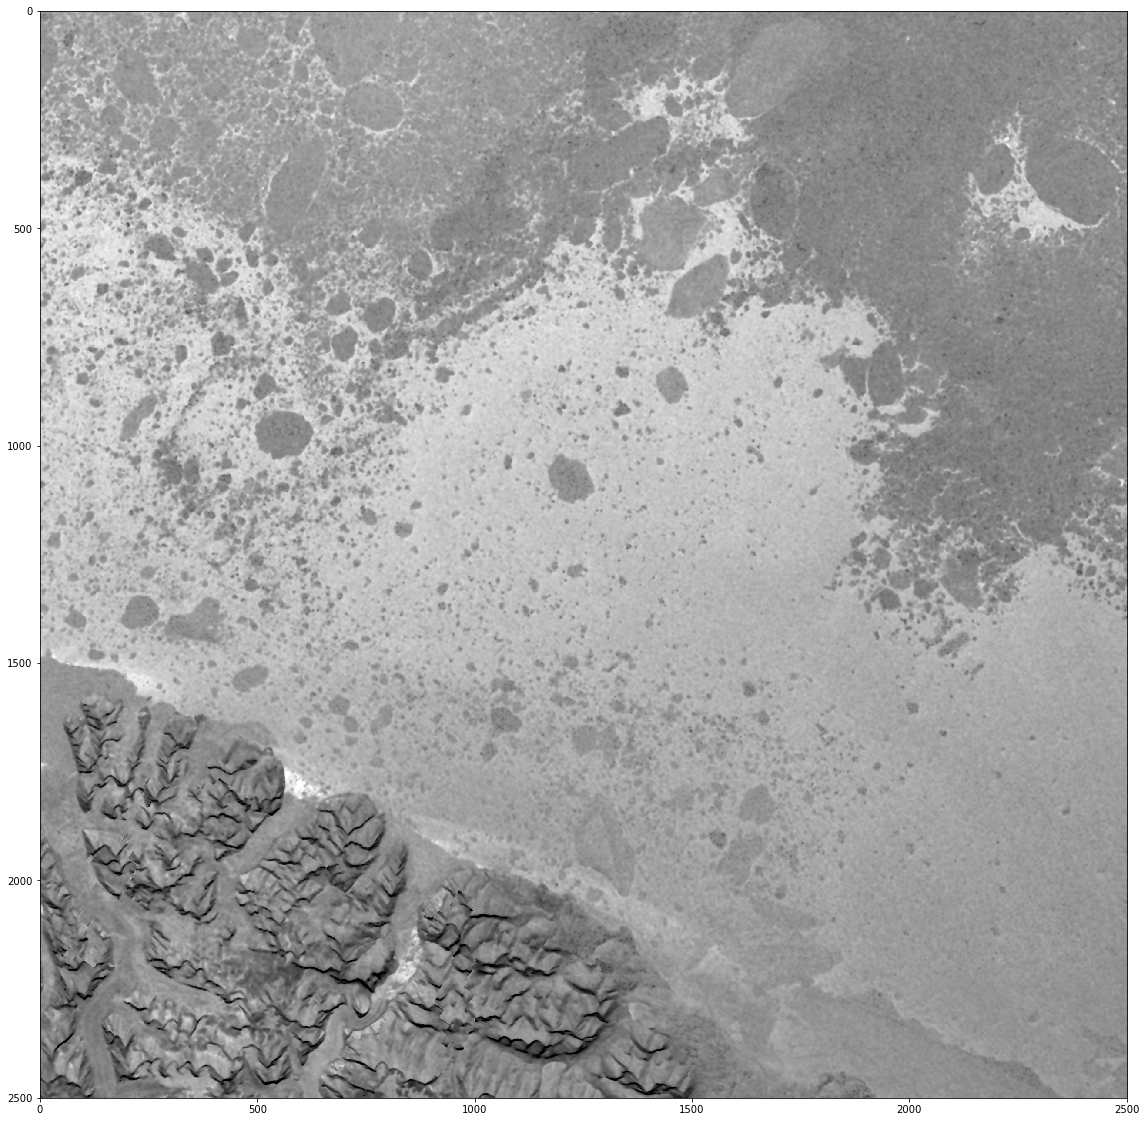

In [35]:
fig = plt.figure(figsize=(20,20))

imgplot = plt.imshow(band.ReadAsArray().astype(np.float),
                         cmap=plt.cm.binary, 
                         vmin=-25, 
                         vmax=5)

plt.show()